In [ ]:
import os

# Importing numpy for linear algebra library
import numpy as np

# Importing matplotlib for graph plotting
import matplotlib.pyplot as plt

# Importing all torchvision required for training such as optimizer and transform
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Importing zipfile to unzip dataset
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "Expression" #name of the folder we want to unzip to

# If the image folder doesn't exist, create new file...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Unzip Expression data
with zipfile.ZipFile("/content/data/Expression/Expression.zip", "r") as zip_ref:
        print("Unzipping Expression data...")
        zip_ref.extractall(image_path)

data/Expression directory exists.
Unzipping Expression data...


In [ ]:
image_path = data_path / "Expression"

# Walkthrough the data to check the length of each directories
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 1 images in 'data/Expression'.
There are 7 directories and 0 images in 'data/Expression/test'.
There are 0 directories and 797 images in 'data/Expression/test/surprise'.
There are 0 directories and 1825 images in 'data/Expression/test/happy'.
There are 0 directories and 1216 images in 'data/Expression/test/neutral'.
There are 0 directories and 111 images in 'data/Expression/test/disgust'.
There are 0 directories and 960 images in 'data/Expression/test/angry'.
There are 0 directories and 1018 images in 'data/Expression/test/fear'.
There are 0 directories and 1139 images in 'data/Expression/test/sad'.
There are 7 directories and 0 images in 'data/Expression/train'.
There are 0 directories and 3205 images in 'data/Expression/train/surprise'.
There are 0 directories and 7164 images in 'data/Expression/train/happy'.
There are 0 directories and 4982 images in 'data/Expression/train/neutral'.
There are 0 directories and 436 images in 'data/Expression/train/disgust'

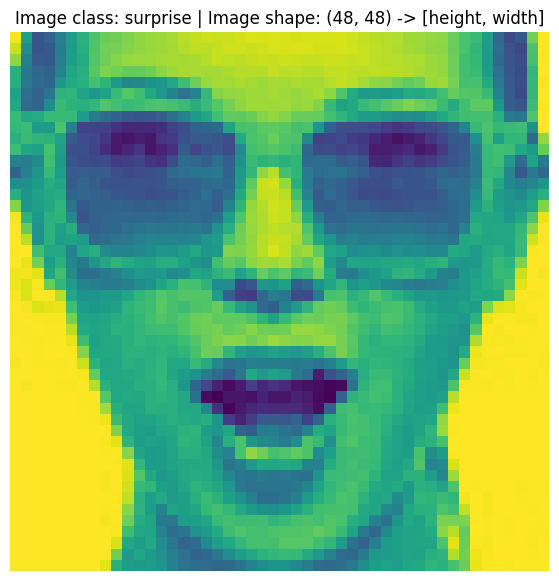

In [ ]:
from PIL import Image
import random

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width]")
plt.axis(False);

In [ ]:
# Image transformation changing to tensor and normalize using mean and standard deviation from imageNet dataset
data_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

In [ ]:
# Use torchvision.datasets.ImageFolder to create dataset(s)
from torchvision import datasets

# Setup train and testing paths
train_dir = image_path / "/content/data/Expression/train"
test_dir = image_path / "/content/data/Expression/test"


train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 28821
    Root location: /content/data/Expression/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 7066
    Root location: /content/data/Expression/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

# Create iterators for the Data loaded using DataLoader module
batchSize = 64

trainloader = DataLoader(dataset=train_data, batch_size=batchSize, num_workers=1, shuffle=True)
testloader = DataLoader(dataset=test_data, batch_size=batchSize, num_workers=1, shuffle=False)

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

28821
7066


In [ ]:
# Defining the FacialExpressionCNN
class FacialExpressionCNN(nn.Module):
    def __init__(self):
        super(FacialExpressionCNN, self).__init__()

        # 1st Convolutional Layer with 3 channel input, 32 channel output and 5x5 kernel size
        self.conv1 = nn.Conv2d(3, 33, 5, groups=3)

        # 2nd Convolutional Layer with 32 channel input, 64 channel output and 5x5 kernel size
        self.conv2 = nn.Conv2d(33, 66, 5, groups=3)

        # 3rd Convolutional Layer with 64 channel input, 128 channel output and 5x5 kernel size
        self.conv3 = nn.Conv2d(66, 132, 5, groups=3)

        # 1st Fully Connected Layer with 512 inputs and 256 output
        self.fc1 = nn.Linear(132 * 2 * 2, 256)

        # 2nd Fully Connected Layer with 256 inputs and 128 output
        self.fc2 = nn.Linear(256, 128)

        # 3rd Fully Connected Layer with 128 inputs and 7 output (because 7 total classes)
        self.fc3 = nn.Linear(128, 7)

        # Max pooling function with kernel_size = 2, stride = 2
        self.pool = nn.MaxPool2d(2, 2)

        # ReLU activation function for each layers
        self.relu = nn.ReLU()


    # Each Convolutional Layers will go through ReLU activation function and max pooling
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 132 * 2 * 2)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Initializing the model using the CNN built above
model = FacialExpressionCNN()

# Initializing the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Moving the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Printing the model summary
print(model)

FacialExpressionCNN(
  (conv1): Conv2d(3, 33, kernel_size=(5, 5), stride=(1, 1), groups=3)
  (conv2): Conv2d(33, 66, kernel_size=(5, 5), stride=(1, 1), groups=3)
  (conv3): Conv2d(66, 132, kernel_size=(5, 5), stride=(1, 1), groups=3)
  (fc1): Linear(in_features=528, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        torch.save(model, 'best_model'+str(epoch)+'.pt')

    return model, history

In [ ]:
# 4. Train the model for 25 epochs

num_epochs = 25
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/25
Epoch : 000, Training: Loss: 1.6421, Accuracy: 34.0967%, 
		Validation : Loss : 1.4590, Accuracy: 43.8579%, Time: 21.7824s
Epoch: 2/25
Epoch : 001, Training: Loss: 1.3674, Accuracy: 47.4064%, 
		Validation : Loss : 1.3577, Accuracy: 46.2638%, Time: 22.2989s
Epoch: 3/25
Epoch : 002, Training: Loss: 1.2517, Accuracy: 52.1321%, 
		Validation : Loss : 1.2824, Accuracy: 51.2171%, Time: 21.9800s
Epoch: 4/25
Epoch : 003, Training: Loss: 1.1660, Accuracy: 55.5845%, 
		Validation : Loss : 1.2228, Accuracy: 53.9909%, Time: 23.0569s
Epoch: 5/25
Epoch : 004, Training: Loss: 1.0919, Accuracy: 58.7384%, 
		Validation : Loss : 1.2261, Accuracy: 54.2740%, Time: 21.5865s
Epoch: 6/25
Epoch : 005, Training: Loss: 1.0139, Accuracy: 61.6113%, 
		Validation : Loss : 1.2343, Accuracy: 53.7220%, Time: 22.7388s
Epoch: 7/25
Epoch : 006, Training: Loss: 0.9414, Accuracy: 64.6404%, 
		Validation : Loss : 1.2162, Accuracy: 55.0948%, Time: 23.2942s
Epoch: 8/25
Epoch : 007, Training: Loss: 0.8661, Accura

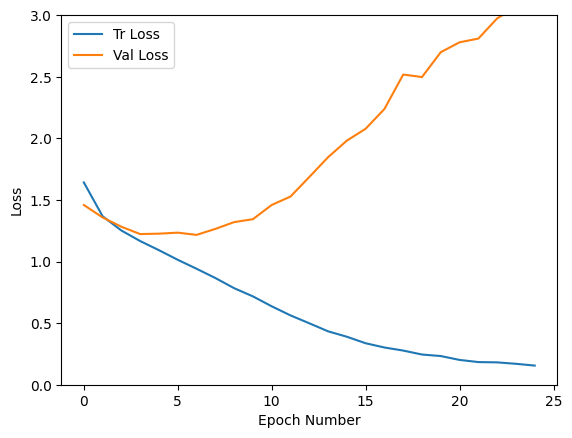

In [ ]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('loss_curve.png')
plt.show()

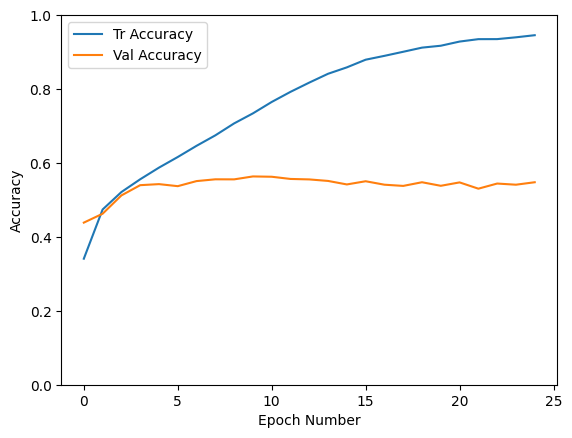

In [ ]:
# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('accuracy_curve.png')
plt.show()